In [1]:
import os
import torch
import numpy as np

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

In [2]:
available = torch.cuda.is_available()
curr_device = torch.cuda.current_device()
device = torch.device("cuda:0" if available else "cpu")
device_count = torch.cuda.device_count() 
device_name =  torch.cuda.get_device_name(0)

print(f'Cuda available: {available}')
print(f'Current device: {curr_device}')
print(f'Device: {device}')
print(f'Device count: {device_count}')
print(f'Device name: {device_name}')

Cuda available: True
Current device: 0
Device: cuda:0
Device count: 1
Device name: NVIDIA A100-SXM4-80GB


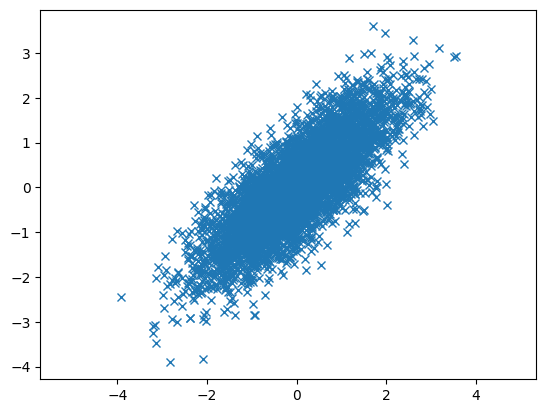

array([[-2.34613269, -0.9714199 ],
       [ 1.1683272 ,  1.37358468],
       [ 0.46140054,  0.57425215],
       [ 0.08226703, -0.4729889 ],
       [-2.06930032, -1.65449209]])

In [3]:
mean = [0, 0]
cov = [[1, 0.8], [0.8, 1]]

X = np.random.multivariate_normal(mean, cov, 5000)

temp = X.T
plt.plot(temp[0], temp[1], 'x')
plt.axis('equal')
plt.show()
X[:5,:]

In [4]:
class Dataset2D(Dataset):
    def __init__(self, data):
        mean = [0, 0]
        cov = [[1, 0.8], [0.8, 1]]
        self.size = len(data)
        self.origX = data 
        self.X = torch.tensor(self.origX).float()

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.X[idx, :]

In [5]:
def backbone(input_width, network_width=10):
    return nn.Sequential(
            nn.Linear(input_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, network_width),
            nn.ReLU(),
            nn.Linear(network_width, input_width),
            nn.Tanh(),
    )


class ResNet(torch.nn.Module):
    def __init__(self, module):
        super(ResNet, self).__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs


class NormalizingFlow2D(nn.Module):
    def __init__(self, num_coupling, width):
        
        super(NormalizingFlow2D, self).__init__()
        self.num_coupling = num_coupling
        self.s = nn.ModuleList([backbone(1, width) for x in range(num_coupling)])
        self.t = nn.ModuleList([backbone(1, width) for x in range(num_coupling)])
        
        # Learnable scaling parameters for outputs of S
        self.s_scale = torch.nn.Parameter(torch.randn(num_coupling))
        self.s_scale.requires_grad = True

    def forward(self, x):
        if model.training:
            s_vals = []
            y1, y2 = x[:, :1], x[:, 1:]
            for i in range(self.num_coupling):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    x1, x2 = y1, y2
                    y1 = x1
                    s = self.s_scale[i] * self.s[i](x1)
                    y2 = torch.exp(s) * x2 + self.t[i](x1)                    
                else:
                    x1, x2 = y1, y2
                    y2 = x2
                    s = self.s_scale[i] * self.s[i](x2)
                    y1 = torch.exp(s) * x1 + self.t[i](x2)
                s_vals.append(s)
          
            # Return outputs and vars needed for determinant
            return torch.cat([y1, y2], 1), torch.cat(s_vals)
        else:
            # Assume x is sampled from random Gaussians
            x1, x2 = x[:, :1], x[:, 1:]
             
            for i in reversed(range(self.num_coupling)):
                # Alternating which var gets transformed
                if i % 2 == 0:
                    y1, y2 = x1, x2
                    x1 = y1
                    s = self.s_scale[i] * self.s[i](y1)
                    x2 = (y2 - self.t[i](y1)) * torch.exp(-s)
                else:
                    y1, y2 = x1, x2
                    x2 = y2
                    s = self.s_scale[i] * self.s[i](y2)
                    x1 = (y1 - self.t[i](y2)) * torch.exp(-s)

            return torch.cat([x1, x2], 1)

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer, report_iters=10):
    size = len(dataloader)
    for batch, X in enumerate(dataloader):
        # Transfer to GPU
        X = X.to(device)
        
        # Compute prediction and loss
        y, s = model(X)
        loss = loss_fn(y, s, batch_size)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % report_iters == 0:
            loss, current = loss.item(), batch
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)
            y, s = model(X)
            test_loss += loss_fn(y, s, batch_size)

    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [7]:
def loss_fn(y, s, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2
    logpx = -torch.sum(0.5 * y**2)
    det = torch.sum(s)
    
    ret = -(logpx + det)
    return torch.div(ret, batch_size)

In [ ]:
learning_rate = 0.001
batch_size = 1000
epochs = 10

model = NormalizingFlow2D(16, 10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

mean = [0, 0]
cov = [[1, 0.8], [0.8, 1]]
training_data = Dataset2D(np.random.multivariate_normal(mean, cov, 20000))
test_data = Dataset2D(np.random.multivariate_normal(mean, cov, 5000))
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
 
print("Done!")

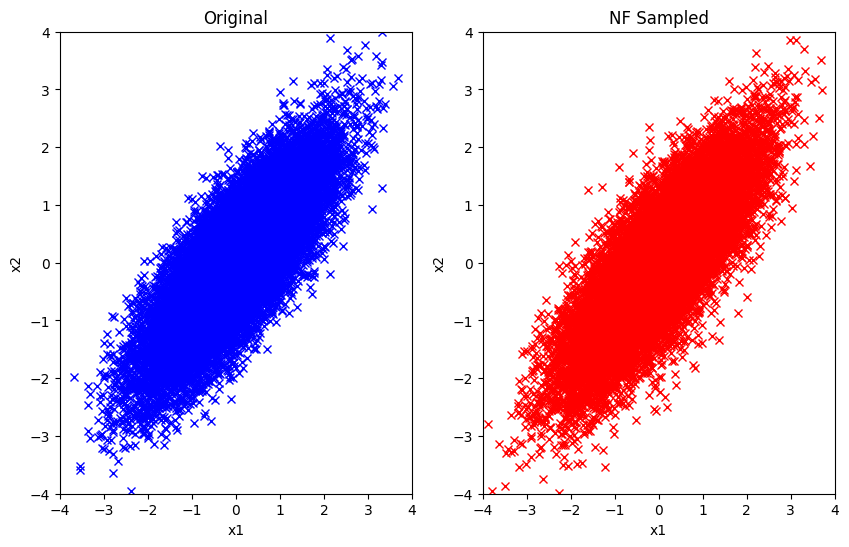

In [12]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10,6))

# subplot1
ax1.set_title("Original")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_xlim(-4, 4)
ax1.set_ylim(-4, 4)

data = training_data.origX.T
ax1.plot(data[0], data[1], 'x', color='blue')

# subplot2
model.eval()
ax2.set_title("NF Sampled")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_xlim(-4, 4)
ax2.set_ylim(-4, 4)
mean = [0, 0]
cov = [[1, 0], [0, 1]]
with torch.no_grad():
    X = torch.Tensor(np.random.multivariate_normal(mean, cov, 20000)).to(device)
    Y = model(X)
samples = Y.cpu().numpy().T
ax2.plot(samples[0], samples[1], 'x', color='red')

In [13]:
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

n_samples = 10000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)[0]
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)[0]
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)[0]
no_structure = np.random.rand(n_samples, 2)


In [ ]:
learning_rate = 0.001
batch_size = 1000
epochs = 100

datasets = [('Noisy Circles', noisy_circles), 
            ('Noisy Moons', noisy_moons),
            ('Blobs', blobs),
            ('Random', no_structure)]
models = []
orig_data = []
for name, dataset in datasets:
    model = NormalizingFlow2D(32, 20).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    training_data = Dataset2D(dataset)
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
   
    print(f"\n======================================\n{name}\n======================================")
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer, report_iters=1)
        
    models.append(model)
    orig_data.append(training_data.origX)

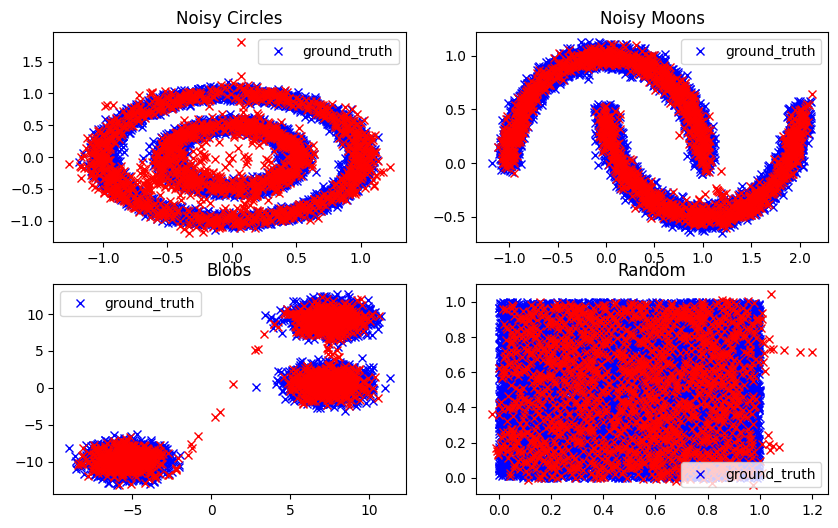

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,6))

for i, ((name, _), ax) in enumerate(zip(datasets, [ax1, ax2, ax3, ax4])):
    # subplot1
    ax.set_title(name)
    
    data = orig_data[i].T
    ax.plot(data[0], data[1], 'x', color='blue', label = 'ground_truth')
    
    # subplot2
    model = models[i].eval()
    mean = [0, 0]
    cov = [[1, 0], [0, 1]]
    with torch.no_grad():
        X = torch.Tensor(np.random.multivariate_normal(mean, cov, 2000)).to(device)
        Y = model(X)
    samples = Y.cpu().numpy().T
    ax.plot(samples[0], samples[1], 'x', color='red')
    ax.legend()